# 卷积神经网络（LeNet）
:label:`sec_lenet`

通过之前几节，我们学习了构建一个完整卷积神经网络的所需组件。
回想一下，之前我们将softmax回归模型（ :numref:`sec_softmax_scratch`）和多层感知机模型（ :numref:`sec_mlp_scratch`）应用于Fashion-MNIST数据集中的服装图片。
为了能够应用softmax回归和多层感知机，我们首先将每个大小为$28\times28$的图像展平为一个784维的固定长度的一维向量，然后用全连接层对其进行处理。
而现在，我们已经掌握了卷积层的处理方法，我们可以在图像中保留空间结构。
同时，用卷积层代替全连接层的另一个好处是：模型更简洁、所需的参数更少。

在本节中，我们将介绍LeNet，它是最早发布的卷积神经网络之一，因其在计算机视觉任务中的高效性能而受到广泛关注。
这个模型是由AT&T贝尔实验室的研究员Yann LeCun在1989年提出的（并以其命名），目的是识别图像 :cite:`LeCun.Bottou.Bengio.ea.1998`中的手写数字。
当时，Yann LeCun发表了第一篇通过反向传播成功训练卷积神经网络的研究，这项工作代表了十多年来神经网络研究开发的成果。

当时，LeNet取得了与支持向量机（support vector machines）性能相媲美的成果，成为监督学习的主流方法。
LeNet被广泛用于自动取款机（ATM）机中，帮助识别处理支票的数字。
时至今日，一些自动取款机仍在运行Yann LeCun和他的同事Leon Bottou在上世纪90年代写的代码呢！

## LeNet

总体来看，(**LeNet（LeNet-5）由两个部分组成：**)(~~卷积编码器和全连接层密集块~~)

* 卷积编码器：由两个卷积层组成;
* 全连接层密集块：由三个全连接层组成。

该架构如 :numref:`img_lenet`所示。

![LeNet中的数据流。输入是手写数字，输出为10种可能结果的概率。](../img/lenet.svg)
:label:`img_lenet`

每个卷积块中的基本单元是一个卷积层、一个sigmoid激活函数和平均汇聚层。请注意，虽然ReLU和最大汇聚层更有效，但它们在20世纪90年代还没有出现。每个卷积层使用$5\times 5$卷积核和一个sigmoid激活函数。这些层将输入映射到多个二维特征输出，通常同时增加通道的数量。第一卷积层有6个输出通道，而第二个卷积层有16个输出通道。每个$2\times2$池操作（步幅2）通过空间下采样将维数减少4倍。卷积的输出形状由批量大小、通道数、高度、宽度决定。

为了将卷积块的输出传递给稠密块，我们必须在小批量中展平每个样本。换言之，我们将这个四维输入转换成全连接层所期望的二维输入。这里的二维表示的第一个维度索引小批量中的样本，第二个维度给出每个样本的平面向量表示。LeNet的稠密块有三个全连接层，分别有120、84和10个输出。因为我们在执行分类任务，所以输出层的10维对应于最后输出结果的数量。

通过下面的LeNet代码，你会相信用深度学习框架实现此类模型非常简单。我们只需要实例化一个`Sequential`块并将需要的层连接在一起。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

class Reshape(torch.nn.Module):
    def forward(self, X):
        return X.view(-1, 1, 28, 28)

# 实现LeNet网络: 
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), # 不重叠在一起. 
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(), # 做全连接层之前, 我们需要flatten. 形成一个二维矩阵, 好做全连接层(矩阵乘积).
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(), # 输入是需要算一下的, 也就是最后一层是多少. 
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

net


Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

我们对原始模型做了一点小改动，去掉了最后一层的高斯激活。除此之外，这个网络与最初的LeNet-5一致。

下面，我们将一个大小为$28 \times 28$的单通道（黑白）图像通过LeNet。通过在每一层打印输出的形状，我们可以[**检查模型**]，以确保其操作与我们期望的 :numref:`img_lenet_vert`一致。

![LeNet 的简化版。](../img/lenet-vert.svg)
:label:`img_lenet_vert`


In [2]:
# 进行测试: 我们初始化一个
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net: # 因为是Sequential, 所以我们可以遍历这个container
    X = layer(X) # so we can watch shape of x. 
    print(layer.__class__.__name__,'output shape: \t',X.shape) # shape of each layer output
    # 所以, 如果以后不知道那一层的形状变成什么样子了我们可以run一下. 就可以得到每层的输出的形状.

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [3]:
"""

那么, 模型我们可以看到的思路:
就是卷积是将输入变小变小, 然后变宽变宽, 变小是指我们的关注的细节变小, 变宽, 是指我们关注的空间pattern(模式)
每一个通道就是没一个空间的pattern. 所以通道是一直在增加的, 而高宽是一直在减小的. 
不断地将空间信息压缩压缩变小,然后通道变多, 就是将压缩的信息抽取出来, 形成一种空间方式, 然后放到不同的通道中去识别.
然后MLP就是将所有这些信息拿出来, 最终通过全连接层很smooth(平滑)的将模型压缩到我们想要的输出. 

所以现在的神经网络最后空间会被压缩到1, 然后通道数成百上千. 最后做全连接输出.

"""


'\n\n那么, 模型我们可以看到的思路:\n就是卷积是将输入变小变小, 然后变宽变宽, 变小是指我们的关注的细节变小, 变宽, 是指我们关注的空间pattern(模式)\n每一个通道就是没一个空间的pattern. 所以通道是一直在增加的, 而高宽是一直在减小的. \n不断地将空间信息压缩压缩变小,然后通道变多, 就是将压缩的信息抽取出来, 形成一种空间方式, 然后放到不同的通道中去识别.\n然后MLP就是将所有这些信息拿出来, 最终通过全连接层很smooth(平滑)的将模型压缩到我们想要的输出. \n\n所以现在的神经网络最后空间会被压缩到1, 然后通道数成百上千. 最后做全连接输出.\n\n'

请注意，在整个卷积块中，与上一层相比，每一层特征的高度和宽度都减小了。
第一个卷积层使用2个像素的填充，来补偿$5 \times 5$卷积核导致的特征减少。
相反，第二个卷积层没有填充，因此高度和宽度都减少了4个像素。
随着层叠的上升，通道的数量从输入时的1个，增加到第一个卷积层之后的6个，再到第二个卷积层之后的16个。
同时，每个汇聚层的高度和宽度都减半。最后，每个全连接层减少维数，最终输出一个维数与结果分类数相匹配的输出。

## 模型训练

现在我们已经实现了LeNet，让我们看看[**LeNet在Fashion-MNIST数据集上的表现**]。


In [4]:
# LeNET在Fashion-MNIST数据集中的表现. 
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size) # loda data

虽然卷积神经网络的参数较少，但与深度的多层感知机相比，它们的计算成本仍然很高，因为每个参数都参与更多的乘法。
如果你有机会使用GPU，可以用它加快训练。


为了进行评估，我们需要[**对**] :numref:`sec_softmax_scratch`中描述的(**`evaluate_accuracy`函数进行轻微的修改**)。
由于完整的数据集位于内存中，因此在模型使用GPU计算数据集之前，我们需要将其复制到显存中。


In [5]:
print(type(net.parameters()))


<class 'generator'>


In [6]:
# 我们要使用GPU了. 

def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module): # 如果是nn.Module实现的. 
        net.eval()  # 设置为评估模式
        if not device: 
            # 如果没有device. 那么我们就看一下net中的第一个参数的device在哪里, 然后直接获取这个参数的device.
            device = next(iter(net.parameters())).device # 
            # net.parameters本质实现的是generator(yield), 所以我们可以封装成为迭代器. 就是实现__iter__方法, 然后从中取出第一个层(next)
            # 然后看看他的device, 因为我们需要我们的网络在一个模型上进行训练.
    
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2) # 累加器. 
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel()) # 算一下accuracy
    return metric[0] / metric[1] # 得到平均的accuracy./home/wakinghours/programming/LiMu-DeepLearning/3_多层感知机

[**为了使用GPU，我们还需要一点小改动**]。
与 :numref:`sec_softmax_scratch`中定义的`train_epoch_ch3`不同，在进行正向和反向传播之前，我们需要将每一小批量数据移动到我们指定的设备（例如GPU）上。

如下所示，训练函数`train_ch6`也类似于 :numref:`sec_softmax_scratch`中定义的`train_ch3`。
由于我们将实现多层神经网络，因此我们将主要使用高级API。
以下训练函数假定从高级API创建的模型作为输入，并进行相应的优化。
我们使用在 :numref:`subsec_xavier`中介绍的Xavier随机初始化模型参数。
与全连接层一样，我们使用交叉熵损失函数和小批量随机梯度下降。


In [7]:
# 为了使用GPU我们还需要对训练做一些改动. 
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d: # 如果是这两个卷积层: 
            nn.init.xavier_uniform_(m.weight)  # 使用xavier方式进行初始化, 使得我们输入和输出方差是差不多的.
            # 保证模型在一开始的时候不要出现参数上面的问题. 例如: 梯度爆炸, 梯度消失 . 
    net.apply(init_weights) # 应用. 
    print('training on', device) # 打印设备
    net.to(device)  # 将net搬到GPU上.
    optimizer = torch.optim.SGD(net.parameters(), lr=lr) # sgd.
    loss = nn.CrossEntropyLoss() # 分类问题.
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc']) # 动画效果
    timer, num_batches = d2l.Timer(), len(train_iter) # 定时器
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3) # 生成累加器.
        net.train() # 开启train模式
        for i, (X, y) in enumerate(train_iter): # 拿出来batch
            timer.start() 
            optimizer.zero_grad() # 清空梯度.
            X, y = X.to(device), y.to(device) # 将我们的输出和输出挪到GPU上去.
            y_hat = net(X) # foward
            l = loss(y_hat, y) # 计算损失.
            l.backward() # backward()
            optimizer.step() # 更新参数
            with torch.no_grad(): # 无梯度空间. 
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        # 然后计算accuracy, 每个epoch计算
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

现在，我们[**训练和评估LeNet-5模型**]。


loss 0.358, train acc 0.868, test acc 0.843
143433.3 examples/sec on cuda:0


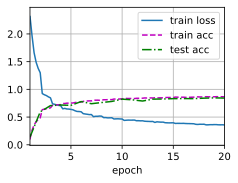

In [8]:
# 训练和评估LeNet-5模型. 
lr, num_epochs = 0.9, 20
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
# 可以看到我们的train acc和test acc基本是重合的, 可见, 没什么overfitting. 
# 那么很有可能是underfitting. 

In [9]:
"""
卷积层实际上就是一个受限的全连接层. 所以在模型复杂度上, 卷积神经网络要小于MLP的. 
所以我们可以看到其实卷积神经网络实际上是更少的过拟合现象. 不过我们应该有一些过拟合, 这是被允许的. 
"""

'\n卷积层实际上就是一个受限的全连接层. 所以在模型复杂度上, 卷积神经网络要小于MLP的. \n所以我们可以看到其实卷积神经网络实际上是更少的过拟合现象. 不过我们应该有一些过拟合, 这是被允许的. \n'

## 小结

* 卷积神经网络（CNN）是一类使用卷积层的网络。
* 在卷积神经网络中，我们组合使用卷积层、非线性激活函数和汇聚层。
* 为了构造高性能的卷积神经网络，我们通常对卷积层进行排列，逐渐降低其表示的空间分辨率，同时增加通道数。
* 在传统的卷积神经网络中，卷积块编码得到的表征在输出之前需由一个或多个全连接层进行处理。
* LeNet是最早发布的卷积神经网络之一。

## 练习

1. 将平均汇聚层替换为最大汇聚层，会发生什么？
1. 尝试构建一个基于LeNet的更复杂的网络，以提高其准确性。
    1. 调整卷积窗口大小。
    1. 调整输出通道的数量。
    1. 调整激活函数（如ReLU）。
    1. 调整卷积层的数量。
    1. 调整全连接层的数量。
    1. 调整学习率和其他训练细节（例如，初始化和轮数）。
1. 在MNIST数据集上尝试以上改进的网络。
1. 显示不同输入（例如毛衣和外套）时，LeNet第一层和第二层的激活值。


[Discussions](https://discuss.d2l.ai/t/1860)
